In [ ]:
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import cv2
import time
from numba import njit
from rembg import remove
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
img = cv2.imread("airline.jpg")

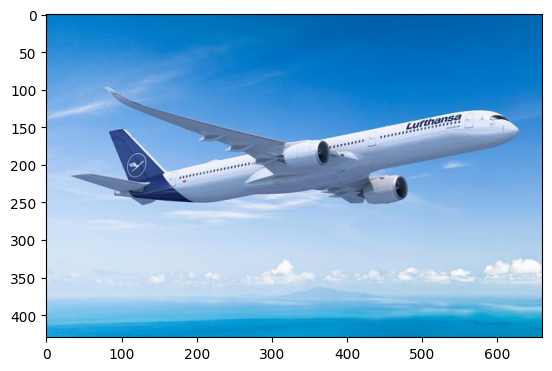

In [26]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
crop_with_alpha = remove(img) 
mask = crop_with_alpha[:, :, 3] / 255.0 

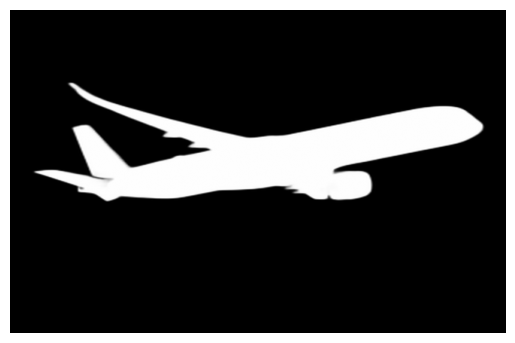

True

In [7]:
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()
cv2.imwrite("airline_mask.png", mask*255)

$$ \Delta u = \Delta f$$
$$ \Delta u(i,j) = u(i+1,j) + u(i-1,j) + u(i,j+1) + u(i,j-1) - 4u(i,j)$$
$$ u(i,j) = (u(i+1,j) + u(i-1,j) + u(i,j+1) + u(i,j-1) - \Delta u(i,j)) \cdot 1/4$$
$$u(i, j) = T(i, j), \quad \text{якщо } (i, j) \in \partial\Omega$$
$u(i, j)$ - шукане рішення (новий колір пікселя).
$T(i, j)$ - колір пікселя фона (Target image).
$\partial\Omega$ - границя маски.

In [40]:
@njit(fastmath=True)
def _numba_seidel(result, lap_source, mask, max_iter):
    h, w, c = result.shape
    for _ in range(max_iter):
        for y in range(1, h - 1):
            for x in range(1, w - 1):
                if mask[y, x] == 1:
                    for ch in range(c):
                        sum_neighbors = (result[y-1, x, ch] + 
                                         result[y+1, x, ch] + 
                                         result[y, x-1, ch] + 
                                         result[y, x+1, ch])
                        result[y, x, ch] = (sum_neighbors + lap_source[y, x, ch]) * 0.25
    return result

In [ ]:
class PoissonBlender:
    def __init__(self):
        self.kernel_laplace = np.array([[0, -1, 0], 
                                        [-1, 4, -1], 
                                        [0, -1, 0]])
        
    def _seidel(self,result, lap_source, mask, max_iter):
        h, w, c = result.shape
        for _ in range(max_iter):
            for y in range(1, h - 1):
                for x in range(1, w - 1):
                    if mask[y, x] == 1:
                        for ch in range(c):
                            sum_neighbors = (result[y-1, x, ch] + 
                                            result[y+1, x, ch] + 
                                            result[y, x-1, ch] + 
                                            result[y, x+1, ch])
                            result[y, x, ch] = (sum_neighbors + lap_source[y, x, ch]) * 0.25
        return result
    
    def _solve_scipy(self, target_roi, lap_source, mask):
        h, w, _ = target_roi.shape
        
        is_mask = (mask == 1)
        mask_ys, mask_xs = np.where(is_mask)
        n_vars = len(mask_ys)
        
        pixel_id_map = -np.ones((h, w), dtype=np.int32)
        pixel_id_map[is_mask] = np.arange(n_vars)

        rows, cols, values = [], [], []
        b = np.zeros((n_vars, 3))

        # Кожне рівняння для пікселя 'i' виглядає так: 
        # 4*P_i - P_up - P_down - P_left - P_right = Lap_source_i
        # Якщо якись сусід, наприклад P_right знаходиться не в масці, то він є відомим з таргета (фона) і тоді
        # 4*P_i - P_up - P_down - P_left = Lap_source_i + P_right

        # Діагональ
        rows.extend(np.arange(n_vars))
        cols.extend(np.arange(n_vars))
        values.extend([4.0] * n_vars)
        
        for ch in range(3):
            b[:, ch] = lap_source[is_mask, ch]

        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:

            neigh_y, neigh_x = mask_ys + dy, mask_xs + dx

            valid = (neigh_y >= 0) & (neigh_y < h) & (neigh_x >= 0) & (neigh_x < w)
            
            neighbor_ids = pixel_id_map[neigh_y[valid], neigh_x[valid]]
            curr_pixel_ids = pixel_id_map[mask_ys[valid], mask_xs[valid]]
            
            in_mask = (neighbor_ids != -1)
            rows.extend(curr_pixel_ids[in_mask])
            cols.extend(neighbor_ids[in_mask])
            values.extend([-1.0] * np.sum(in_mask))

            is_boundary = (neighbor_ids == -1)
            if np.any(is_boundary):
                by, bx = neigh_y[valid][is_boundary], neigh_x[valid][is_boundary]
                target_pixel_ids = curr_pixel_ids[is_boundary]
                
                for ch in range(3):
                    b[target_pixel_ids, ch] += target_roi[by, bx, ch]

        A = sparse.coo_matrix((values, (rows, cols)), shape=(n_vars, n_vars)).tocsc()
        
        result_roi = target_roi.copy()
        for ch in range(3):
            solved_values = spsolve(A, b[:, ch])

            result_roi[is_mask, ch] = np.clip(solved_values, 0, 1)

        return result_roi

    def blend(self, target_img, source_img, mask_img, offset=(0, 0), method='scipy', max_iter=2000):

        target = target_img.astype(np.float64) / 255.0
        source = source_img.astype(np.float64) / 255.0
        mask = (mask_img > 128).astype(np.float64)
        if mask.ndim == 3: mask = mask[:,:,0]

        oy, ox = offset
        sh, sw = source.shape[:2]
        target_roi = target[oy:oy+sh, ox:ox+sw].copy()

        lap_source = np.zeros_like(source)
        for i in range(3):
            lap_source[:,:,i] = cv2.filter2D(source[:,:,i], -1, self.kernel_laplace)

        start_t = time.time()
        if method == 'scipy':
            print("Розвязок за допомогою SciPy")
            result_roi = self._solve_scipy(target_roi, lap_source, mask)
        elif method == 'seidel':
            print(f"Розвязок за допомогою метода Зейделя, {max_iter} ітерацій.")
            result_roi = self._seidel(target_roi, lap_source, mask, max_iter)
        else:
            print(f"Розвязок за допомогою метода Зейделя + прискорення numba, {max_iter} ітерацій.")
            result_roi = _numba_seidel(target_roi.copy(), lap_source, mask, max_iter)
        duration = time.time() - start_t
        print(f"Завершено за {duration:.4f} сек.")
        
        final_result = target.copy()
        final_result[oy:oy+sh, ox:ox+sw] = result_roi
        return (np.clip(final_result, 0, 1) * 255).astype(np.uint8), duration

Розвязок за допомогою SciPy
Завершено за 0.5950 сек.


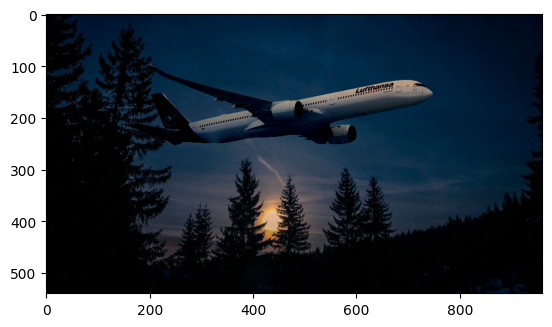

In [ ]:
target = cv2.imread("night.jpg")
source = cv2.imread("airline.jpg")     
mask = cv2.imread("airline_mask.png", 0) 

blender = PoissonBlender()

# offset=(y, x) - де буде лівий верхній кут source
result, _ = blender.blend(target, source, mask, offset=(0, 120), method='scipy')

cv2.imwrite("final_result.jpg", result)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

(np.float64(-0.5), np.float64(959.5), np.float64(539.5), np.float64(-0.5))

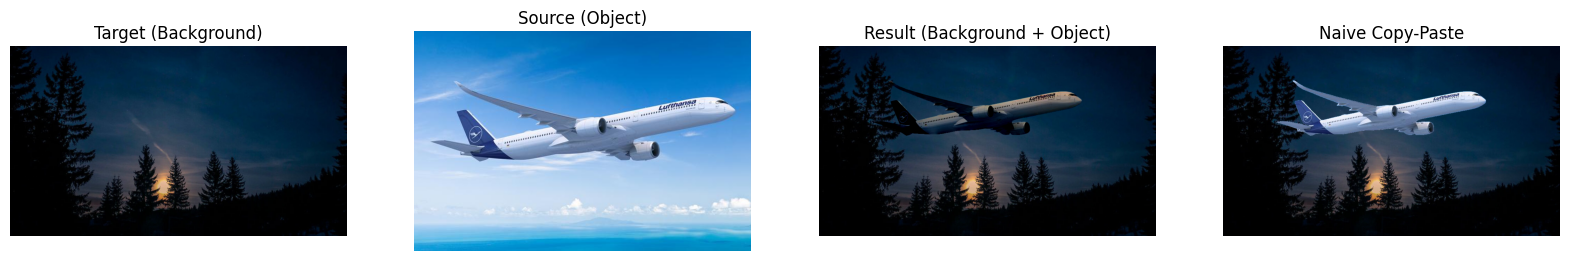

In [100]:
offset = (0, 120)
naive_result = target.copy()
oy, ox = offset
h, w = source.shape[:2]
roi = naive_result[oy:oy+h, ox:ox+w]
mask_bool = (mask > 128)
roi[mask_bool] = source[mask_bool]
naive_result[oy:oy+h, ox:ox+w] = roi
plt.figure(figsize=(20, 12))
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(target, cv2.COLOR_BGR2RGB))
plt.title("Target (Background)")
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(source, cv2.COLOR_BGR2RGB))
plt.title("Source (Object)")
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Result (Background + Object)")
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(naive_result, cv2.COLOR_BGR2RGB))
plt.title("Naive Copy-Paste")
plt.axis('off')

In [93]:
def create_synthetic_data(size=400):
    x = np.linspace(0, 1, size)
    y = np.linspace(0, 1, size)
    xv, yv = np.meshgrid(x, y)

    target_gray = (np.sin(4 * np.pi * xv) * np.cos(4 * np.pi * yv) + 1) / 2
    target_gray = (target_gray * 255).astype(np.uint8)
    
    target = cv2.merge([
        (target_gray * 0.5).astype(np.uint8),
        target_gray,                         
        (target_gray * 0.3).astype(np.uint8)  
    ])
    
    source = np.zeros((size, size, 3), dtype=np.uint8)
    cv2.circle(source, (size//2, size//2), size//4, (13, 0, 120), -1)

    mask = np.zeros((size, size), dtype=np.uint8)
    cv2.circle(mask, (size//2, size//2), size//4, 255, -1)
    
    return target, source, mask

Розвязок за допомогою метода Зейделя + прискорення numba, 1 ітерацій.
Завершено за 0.3071 сек.
Розвязок за допомогою SciPy
Завершено за 0.5757 сек.
Size 50x50, Method scipy: 0.5757s
Розвязок за допомогою метода Зейделя, 1500 ітерацій.
Завершено за 2.7381 сек.
Size 50x50, Method seidel: 2.7381s
Розвязок за допомогою метода Зейделя + прискорення numba, 1500 ітерацій.
Завершено за 0.0185 сек.
Size 50x50, Method numba: 0.0185s
Розвязок за допомогою SciPy
Завершено за 0.1524 сек.
Size 100x100, Method scipy: 0.1524s
Розвязок за допомогою метода Зейделя, 1500 ітерацій.
Завершено за 12.6662 сек.
Size 100x100, Method seidel: 12.6662s
Розвязок за допомогою метода Зейделя + прискорення numba, 1500 ітерацій.
Завершено за 0.0841 сек.
Size 100x100, Method numba: 0.0841s
Розвязок за допомогою SciPy
Завершено за 0.1912 сек.
Size 150x150, Method scipy: 0.1912s
Розвязок за допомогою метода Зейделя, 1500 ітерацій.
Завершено за 26.9803 сек.
Size 150x150, Method seidel: 26.9803s
Розвязок за допомогою метод

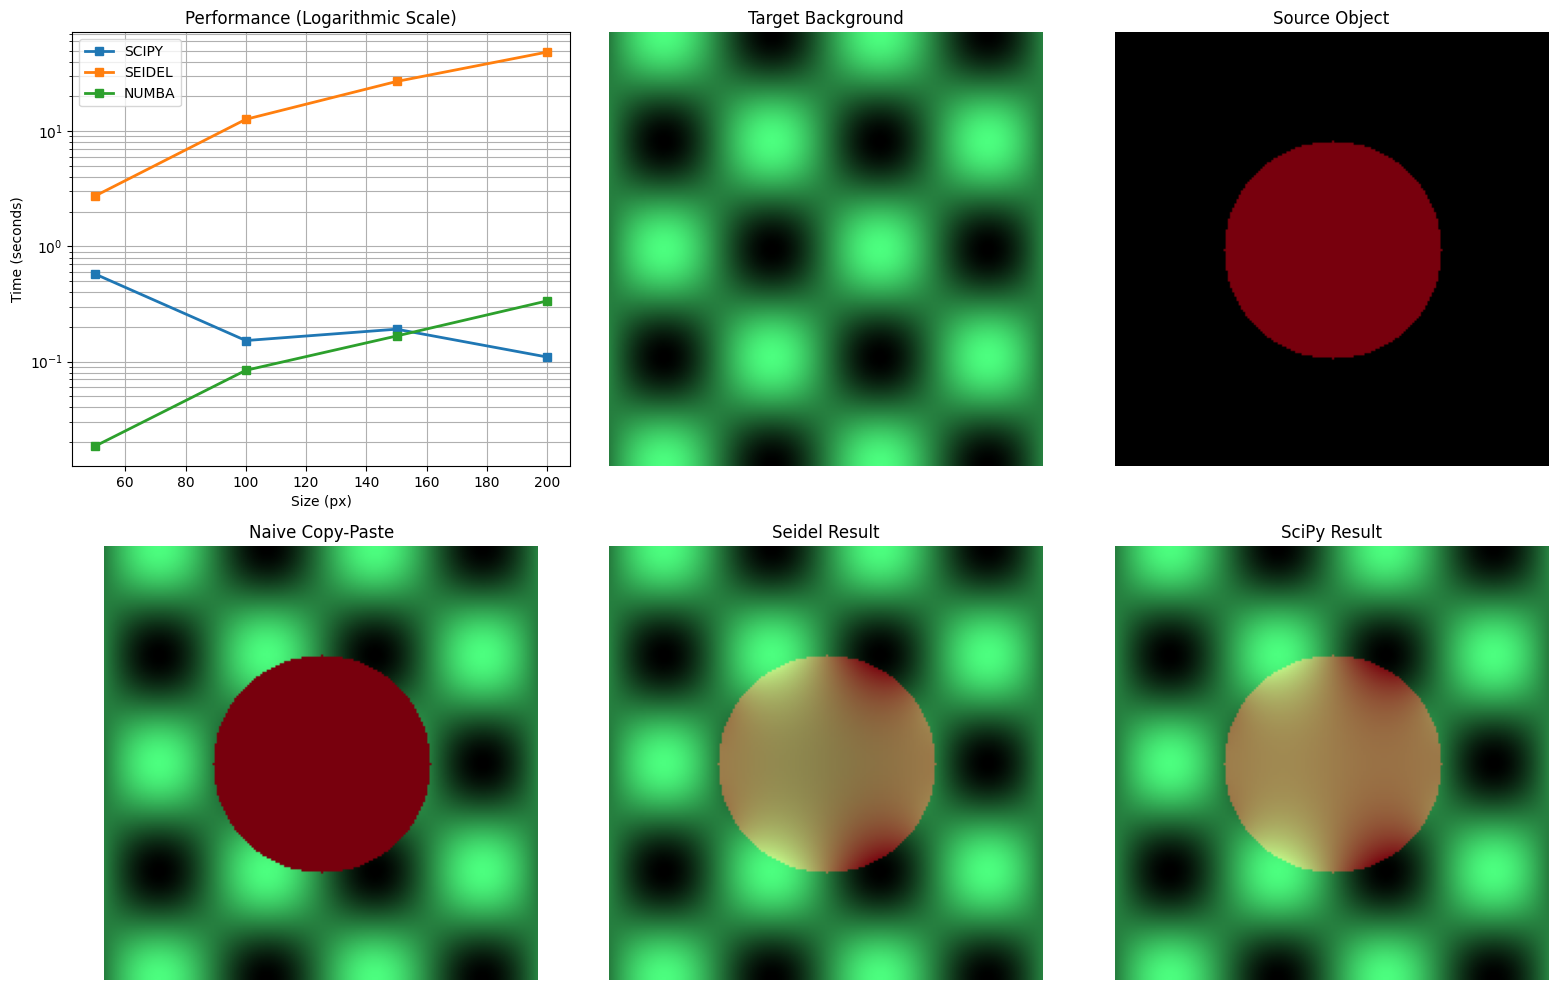

In [101]:
sizes = [50, 100, 150, 200]
methods = ['scipy', 'seidel', 'numba']
results_time = {m: [] for m in methods}
blender = PoissonBlender()

t, s, m = create_synthetic_data(50)
blender.blend(t, s, m, method='numba', max_iter=1)

for sz in sizes:
    t_img, s_img, m_img = create_synthetic_data(sz)
    for m in methods:
        _, dur = blender.blend(t_img, s_img, m_img, method=m, max_iter=1500)
        results_time[m].append(dur)
        print(f"Size {sz}x{sz}, Method {m}: {dur:.4f}s")

t_final, s_final, m_final = create_synthetic_data(200)
naive_res = t_final.copy()
mask_3d = np.repeat(m_final[:, :, np.newaxis], 3, axis=2) 
mask_bool = (mask_3d > 0)
naive_res[mask_bool] = s_final[mask_bool]
res_scipy, _ = blender.blend(t_final, s_final, m_final, method='scipy')
res_seidel, _ = blender.blend(t_final, s_final, m_final, method='numba', max_iter=2000)

plt.figure(figsize=(16, 10))


plt.subplot(2, 3, 1)
for m in methods:
    plt.plot(sizes, results_time[m], marker='s', linewidth=2, label=m.upper())
plt.yscale('log')
plt.title("Performance (Logarithmic Scale)")
plt.xlabel("Size (px)"); plt.ylabel("Time (seconds)"); plt.legend(); plt.grid(True, which="both", ls="-")


plt.subplot(2, 3, 2)
plt.imshow(cv2.cvtColor(t_final, cv2.COLOR_BGR2RGB))
plt.title("Target Background")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(s_final, cv2.COLOR_BGR2RGB))
plt.title("Source Object")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(cv2.cvtColor(naive_res, cv2.COLOR_BGR2RGB))
plt.title("Naive Copy-Paste"); plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(cv2.cvtColor(res_seidel, cv2.COLOR_BGR2RGB))
plt.title("Seidel Result")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(cv2.cvtColor(res_scipy, cv2.COLOR_BGR2RGB))
plt.title("SciPy Result")
plt.axis('off')

plt.tight_layout()
plt.show()